
# Federated Learning

## Frecency Sampling

To be able to quickly prototype the Federated Learning algorithm, a dataset is required.
This notebook is based on a fake frecency dataset that was designed to be very interpretable and at the same time close to the actual data.
The assumption for the data generation is that the current frecency algorithm is perfect. By sampling based on this axiom, we can check if the algorithm really finds the global optimum.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Sampling the model input

These are weights that describe how common certain features are. For `recency` we assume a uniform distribution over time, for `type` numbers were chosen that intuitively seem to be reasonable.

In [2]:
type_weights = {
    "visited": 0.6,
    "typed": 0.2,
    "bookmarked": 0.2,
    #"other_type": 0.1
}

**Note:** Actually there's also a feature `other_type` which has a weight of `0` in the original frecency algorithm, i.e. it's not really used. If we use this feature for this training process, it adds noise to the model because the model has not enough data to learn that this feature does not really add value. 

In [3]:
recency_weights = {
    "4-days": 0.03,
    "14-days": 0.05,
    "31-days": 0.1,
    "90-days": 0.32,
    "other_recency": 0.5
}

For the simulation, it seems to be a fair assumption that `type` and `recency` are independent of each other.
This means we can just multiply the probabilities.

This is probably not completely true, since users likely visit bookmarks more often, but it makes things easier here and the probabilities are hard to estimate well anyways.

In [5]:
def combine_dicts_multiplicatively(dict1, dict2):
    """
    Returns a new dict where the keys consist of all pairs of keys from the input
    dictionaries and the values correspond to the respective multiplied values.
    """
    weights = {}

    for key1, weight1 in dict1.items():
        for key2, weight2 in dict2.items():
            key = (key1, key2)
            weight = weight1 * weight2
            weights[key] = weight
            
    return weights

In [6]:
weights = combine_dicts_multiplicatively(type_weights, recency_weights)

A one-hot representation makes it easier to implement the rest of the formulas. numpy allows us to generate this easily using a permutation of the identity matrix.

In [7]:
def one_hot(num_choices, vector):
    return np.eye(num_choices)[vector]

The input vector to the model is 20-dimensional: One field for every combination of `type` and `recency`.
In the frecency algorithm, we consider the last ten visits to the URL.
Thus, the sum of all elements of the vector is a natural number between 1 and 10.

(Since `other-type` is commented out, it's only 15-dimensional for now.)

In [8]:
def sample_weighted(num_samples, weight_dict):
    """Randomly sample from a dict using the values as probabilities"""
    num_choices = len(weight_dict)
    choice_weights = weight_dict.values()
    samples = np.random.choice(num_choices, num_samples, p=choice_weights)
    return one_hot(num_choices, samples)

In [9]:
def sample_url_features(num_samples):
    return sample_weighted(num_samples, weights)

### Sampling the target labels

These are the weights found in the current frecency algorithm. Based on the one-hot encoding, this is just a linear function.

In [10]:
type_points = {
    "visited": 1.2,
    "typed": 2,
    "bookmarked": 1.4,
    #"other_type": 0
}

In [11]:
recency_points = {
    "4-days": 100,
    "14-days": 70,
    "31-days": 50,
    "90-days": 30,
    "other_recency": 10
}

In [12]:
frecency_points_dict = combine_dicts_multiplicatively(type_points, recency_points)

To make sure that the order of keys is the same everywhere:

In [13]:
key_order = weights.keys()
frecency_points = np.array([frecency_points_dict[key] for key in key_order])

This gives us the frecency points from the original algorithm:

In [15]:
zip(key_order, frecency_points)

[(('visited', '4-days'), 120.0),
 (('visited', '90-days'), 36.0),
 (('bookmarked', '14-days'), 98.0),
 (('bookmarked', 'other_recency'), 14.0),
 (('typed', 'other_recency'), 20.0),
 (('typed', '31-days'), 100.0),
 (('typed', '14-days'), 140.0),
 (('bookmarked', '31-days'), 70.0),
 (('typed', '4-days'), 200.0),
 (('bookmarked', '90-days'), 42.0),
 (('visited', '31-days'), 60.0),
 (('bookmarked', '4-days'), 140.0),
 (('visited', 'other_recency'), 12.0),
 (('typed', '90-days'), 60.0),
 (('visited', '14-days'), 84.0)]

After all these preparations, an arbitrary number of frecency scores can be computed using a single matrix multiplication.

In [16]:
def frecency(url_features):
    return url_features.dot(frecency_points)

Finally, we are sampling from the above distributions and then call the frecency function.

In [17]:
def sample(num_samples):
    X = sample_url_features(num_samples)
    y = frecency(X)
    return X, y

## Linear Regression

This section is mostly to check that's it possible to fit a linear model perfectly to the data.

In [18]:
from sklearn.linear_model import LinearRegression

To fit a model, we sample a lot of these scores and also add noise on top to make the problem more similar to the real application.

In [19]:
n = int(1e6)
noise = np.random.normal(0, 2, size=(n))
X, y = sample(n)
y += noise

In [20]:
model = LinearRegression(fit_intercept=False)

In [21]:
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

The resulting coefficients are extremely close to the actual frecency weights. How close they are depends on how much noise we add to the data matrix.

In [22]:
zip(model.coef_, frecency_points)

[(120.00857174123152, 120.0),
 (35.992374329252499, 36.0),
 (98.009679407084931, 98.0),
 (13.994036991286437, 14.0),
 (19.997969525275028, 20.0),
 (100.00525467300019, 100.0),
 (140.00535170497776, 140.0),
 (70.006640174834345, 70.0),
 (200.03664835231191, 200.0),
 (42.004912094290368, 42.0),
 (60.007841509769776, 60.0),
 (139.92209908360906, 140.0),
 (11.999563388013492, 12.0),
 (59.997270917600559, 60.0),
 (84.006283264096965, 84.0)]

In [23]:
model.coef_ - frecency_points

array([ 0.00857174, -0.00762567,  0.00967941, -0.00596301, -0.00203047,
        0.00525467,  0.0053517 ,  0.00664017,  0.03664835,  0.00491209,
        0.00784151, -0.07790092, -0.00043661, -0.00272908,  0.00628326])

## Ranking

Now, we make the problem slightly more difficult: Instead of just learning the frecency function from data, we try to learn it from user interactions. The training data now consists of a variable number of history suggestions and their respective features. The label corresponds to the suggestion that the user clicked on. We still assume that the user clicks on the item with the highest frecency score.

In [24]:
n = int(1e3)

How many suggestions match the search query is sampled from a normal distribution centered around `10`.

In [26]:
num_options = np.random.normal(loc=10, scale=4, size=(n))
num_options = np.maximum(num_options, 1)
num_options = np.int32(num_options)

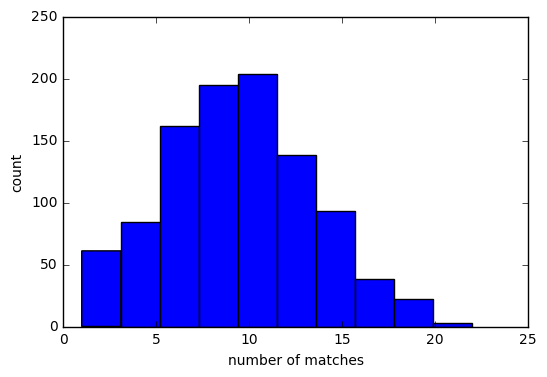

In [27]:
plt.hist(num_options)
plt.xlabel("number of matches")
plt.ylabel("count")

## Hinge Loss

After preparing the training data, we can try to use the adapted SVM loss (also called [hinge loss](https://en.wikipedia.org/wiki/Hinge_loss)) for ranking.

In [31]:
X, y = zip(*[sample(n) for n in num_options])

Gradient descent generally works better when the data is centered around the origin:

In [32]:
def flatten(X):
    X_flat = []

    for x in X:
        X_flat += list(x)

    return np.array(X_flat)

In [33]:
def normalize(X):
    X_flat = flatten(X)
    mu = X_flat.mean(axis=0)
    return [x - mu for x in X]

In [34]:
X = normalize(X)

The optimizer we use is fairly simple: It scales the gradient with a learning rate before adding it to the model.
This abstraction as a class is still nice because we can later replace it with more sophisticated optimizers.

In [35]:
class GradientDescent:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        
    def __call__(self, gradient):
        return self.learning_rate * gradient

To supervise training, we keep logging the loss:

In [36]:
def svm_loss(preds, ys):
    correct = ys.argmax()
    score_correct = preds[correct]
    
    loss = 0
    
    for i, pred in enumerate(preds):
        if i != correct and pred > score_correct:
            loss += pred - score_correct
            
    return loss

The `SVMRanking` class is the main mechanism for fitting models.

In [53]:
class SVMRanking:
    def __init__(self, delta):
        self.delta = delta
        
    def fit(self, X, y, optimizer, num_iterations=10):
        num_features = X[0].shape[1]
        
        np.random.seed(0)
        self.W = frecency_points + (np.random.random(size=(num_features)) - 0.5) * 50
        
        for j in range(num_iterations):
            preds = self.predict(X)
            gradient = np.zeros(num_features)
            loss = 0
            
            for xi, pi, yi in zip(X, preds, y):
                correct = yi.argmax()
                score_correct = pi[correct]
                
                if pi.argmax() != correct: # Wrong pred, let's ignore delta for now
                    for i, predicted_score in enumerate(pi):
                        if i != correct and predicted_score > score_correct:
                            gradient -= xi[i]
                            
                loss += svm_loss(pi, yi)
            
            # / 100 just to make it easier to parse
            loss /= len(X) / 100
            gradient /= len(X)
            self.W += optimizer(gradient)
            
            if j % (num_iterations / 20) == 0:
                print(loss)
                
            if loss < 0.05:
                break
    
    def predict(self, X):
        preds = []
        
        for x in X:
            scores = x.dot(self.W)
            preds.append(scores)
        
        return preds

In [54]:
model = SVMRanking(delta=1)
model.fit(X, y, optimizer=GradientDescent(.75), num_iterations=3000)

429.843103345
218.361583462
78.3765090899
57.3335639678
42.4594006889
30.5899160192
23.0474973035
15.6816449125
8.11178555738
0.677141516191


After fitting, we can compare the learned weights with the true frecency scores. If sorted by influence, they are nearly the same. To increase the margins between them, the `delta` parameter still has to be implemented.

In [55]:
ais = np.argsort(frecency_points)
zip(frecency_points[ais], model.W[ais])

[(12.0, 31.15989523099319),
 (14.0, 31.139571634029117),
 (20.0, 31.379097780104424),
 (36.0, 46.352748949157061),
 (42.0, 46.356357889837028),
 (60.0, 55.568726492913612),
 (60.0, 55.587676284097356),
 (70.0, 67.302202337714363),
 (84.0, 67.355709489400496),
 (98.0, 104.675418909024),
 (100.0, 110.36920586421327),
 (120.0, 125.69131864849851),
 (140.0, 138.04070440539326),
 (140.0, 138.04146219388386),
 (200.0, 224.12790631902101)]

accuracy needs to be measured carefully here: In our simulation, we assume that the current frecency is the perfect ranking function. But because items sometimes get the same frecency scores, there can be more than one correct answer:

In [56]:
def rank_accuracy(y, preds):
    correct = 0.
    
    for yi, pi in zip(y, preds):
        if yi[pi.argmax()] == yi.max():
            correct += 1
            
    return correct / len(y)

This number tells us how often our model predicted the correct answer:

In [57]:
rank_accuracy(y, model.predict(X))

0.995

---

### Debugging

This part is just for checking wrong predictions:

In [ ]:
preds = [t.argmax() for t in model.predict(X)]

In [ ]:
labels = [yi.argmax() for yi in y]

In [ ]:
zip(range(len(labels)), labels, preds)[:20]

In [ ]:
y[5]

In [ ]:
model.predict(X)[5]

In [ ]:
X[9][2]

# Backup

### Random noise

In [ ]:
y = [yi + np.random.normal(0, 2, size=(n)) for yi, n in zip(y, num_options)]

### Other optimizers

In [ ]:
class DecayedGradientDescent:
    def __init__(self, learning_rate, decay):
        self.learning_rate = learning_rate
        self.decay = decay
        self.epoch = 0
        
    def __call__(self, gradient):
        result = self.learning_rate * gradient
        
        self.learning_rate = self.learning_rate * 1 / (1 + self.decay * self.epoch)
        self.epoch += 1
            
        return result

In [ ]:
model = SVMRanking(delta=1)
model.fit(X, y, optimizer=DecayedGradientDescent(0.5, .0000001), num_iterations=3000)

In [ ]:
class Adam:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.alpha = 0.01
        self.eps = 1e-8
        
        self.t = 0
        
        self.m = None
        self.v = None
        self.theta = None
    
    def __call__(self, gradient):
        if self.t == 0:
            self.m = np.zeros(gradient.shape)
            self.v = np.zeros(gradient.shape)
            self.theta = np.zeros(gradient.shape)
        
        self.t += 1
        
        self.m = self.beta1 * self.m + (1 - self.beta1) * gradient
        self.v = self.beta2 * self.v + (1 - self.beta2) * gradient**2
        
        m_corrected = self.m / (1 - self.beta1**self.t)
        v_corrected = self.v / (1 - self.beta2**self.t)

        self.theta += self.alpha * m_corrected / (np.sqrt(v_corrected) + self.eps)
        
        return self.learning_rate * self.theta

In [ ]:
opt = Adam(learning_rate=0.1)
model = SVMRanking(delta=1)
model.fit(X, y, optimizer=opt, num_iterations=200)

In [ ]:
opt.theta